# 导入依赖

In [1]:
from skimage import io,transform,color
from sklearn import preprocessing
import numpy as np
import tensorflow as tf
import warnings
import pydot,gc
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential,load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.optimizers import SGD, Adam
from keras.utils import np_utils,plot_model
from keras.callbacks import EarlyStopping
from keras import backend as K
from numba import cuda
import csv
import matplotlib.pyplot as plt
from keras import regularizers

Using TensorFlow backend.


In [30]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config)) # 此处不同

# 读取图片
默认大小为512*512*1,对图像做灰度化处理，减少内存占用
生成标签：独热码，将图片的11个种类编码

In [3]:
#图片路径
train_addr_prex = "food-11\\food-11\\training\\"
train_addr_addix = "_*.jpg"

#获得其图像数量
train = io.ImageCollection(train_addr_prex+'*.jpg')
num = len(train)
del train
gc.collect()

#初始化变量
Train_x = []
Train_y = []
label = []
former = 0
batch_size = []
train_num = 0

#对图像处理变成(512,512,1)并生成标签
for i in range(11):
    #先读入一个种类批次图片
    Train_batch = io.ImageCollection(train_addr_prex+str(i)+train_addr_addix)
    #忽略警告，ps:图片或许会有损坏，报警告但不影响后续处理
    warnings.filterwarnings('ignore')
    #将本种类图片数量写入列表中
    batch_size.append(len(Train_batch))
    if i > 0:
        former = former +  batch_size[i-1]
    for j in range(batch_size[i]):   
        #对图像灰度化处理，并完成缩放，shape为[1,512,512,1]        
        Train_x.append(transform.resize(Train_batch[j],(128,128)))
        label.append(i) 
Train_x = np.array(Train_x).reshape(-1,128,128,3)
#np_utils编码        
Train_y = np_utils.to_categorical(label,num_classes=11,dtype='uint8')#.reshape(num,11).astype("uint8")


In [4]:
#图片路径
valid_addr_prex = "food-11\\food-11\\validation\\"
valid_addr_addix = "_*.jpg"

#获得其图像数量
valid = io.ImageCollection(valid_addr_prex+'*.jpg')
num = len(valid)
del valid

#初始化变量
Valid_x = []
#np.empty((num,512,512),dtype="float32")
Valid_y = []
va_label = []
va_former = 0
va_batch_size = []
va_num = 0

#对图像处理变成(512,512,1)并生成标签
for i in range(11):
    #先读入一个种类批次图片
    Valid_batch = io.ImageCollection(valid_addr_prex+str(i)+valid_addr_addix)
    #忽略警告，ps:图片或许会有损坏，报警告但不影响后续处理
    warnings.filterwarnings('ignore')
    #将本种类图片数量写入列表中
    va_batch_size.append(len(Valid_batch))
    if i > 0:
        va_former = va_former +  va_batch_size[i-1]
    for j in range(va_batch_size[i]):   
        #对图像灰度化处理，并完成缩放，shape为[1,512,512,1]
        #Valid_x[va_former+j,:,:] = transform.resize(color.rgb2gray(Valid_batch[j]), (512,512))
        #Valid_x[va_former+j,:,:] = transform.resize(Valid_batch[j], (512,512))        
        Valid_x.append(transform.resize(Valid_batch[j], (128,128)) )
        va_label.append(i) 
        
Valid_x = np.array(Valid_x).reshape(-1,128,128,3)
#np_utils编码        
Valid_y = np_utils.to_categorical(va_label, num_classes=11, dtype='uint8')#.reshape(num,11).astype("uint8")

# 搭建模型(CNN)
CONV - MAXPOOLING - CONV - MAXPOOLING - FLATTEN - DENSE - DENSE - SOFTMAX - OUTPUT

In [ ]:

#序列模型
model = Sequential()
#一层卷积层,32个卷积核,卷积层，BN，激活函数
#128*128*3
model.add(Conv2D(filters=32,
                 kernel_size=(3,3),
                 strides=1,
                 padding='same',
                 input_shape=(128,128,3),
                 #activation='relu',
                ))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))

model.add(Conv2D(32,(3,3),padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))

#最大池化
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#64*64*32

#卷积层，64个卷积核
model.add(Conv2D(64,(3,3),padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))

model.add(Conv2D(64,(3,3),padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))

#最大池化
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#32*32*64

#卷积层，128个卷积核
model.add(Conv2D(128,(3,3),padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))

model.add(Conv2D(128,(3,3),padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))

#最大池化
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#16*16*128

#卷积层，512个卷积核
model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))

model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))

#最大池化
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#8*8*512

#扁平化
model.add(Flatten())
#全连接层，1024个Neurons
model.add(BatchNormalization(axis=-1))
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.4))

##全连接层，11个Neurons,softmax输出
model.add(Dense(11,activation='softmax'))

#早停策略，当训练集精度不再上升时，再容忍2次迭代便停止训练
early_stopping = EarlyStopping(monitor='val_acc', patience=5, verbose=1)

#编译模型，Adam优化
adam = Adam(lr=0.0001)
#sgd = SGD(lr=0.001, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics = ['accuracy'])

#开始训练
train_history = model.fit(x=Train_x,y=Train_y, epochs=300, batch_size=15, validation_data=(Valid_x,Valid_y), verbose=1, shuffle=True, callbacks=[early_stopping])

Train on 9866 samples, validate on 3430 samples
Epoch 1/300


# VGG16

In [ ]:
#序列模型
model = Sequential()
#Input 128*128*3
#Layer1 CONV 64
model.add(Conv2D(filters=64,
                 kernel_size=(3,3),
                 strides=1,
                 padding='same',
                 input_shape=(128,128,3),
                 activation='relu',
                ))
#Layer2 CONV 64
model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
#Layer3 MaxPooling
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2,2)))

#64*64*64
#Layer4 CONV 128
model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
#Layer5 CONV 128
model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
#Layer6 MaxPooling
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2,2)))

#32*32*128
#Layer7 CONV 256
model.add(Conv2D(256,(3,3),padding='same',activation='relu'))
#Layer8 CONV 256
model.add(Conv2D(256,(3,3),padding='same',activation='relu'))
#Layer9 MaxPooling
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2,2)))

#16*16*256
#Layer10 Dense1024
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.4))

#Layer11 Dense1024
model.add(Dense(100,activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(Dropout(0.4))

#Layer11 Dense11
model.add(Dense(11,activation='softmax'))

#早停策略，当训练集精度不再上升时，再容忍2次迭代便停止训练
early_stopping = EarlyStopping(monitor='val_acc', patience=5, verbose=1)

#编译模型，Adam优化
adam = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics = ['accuracy'])

#开始训练
train_history = model.fit(x=Train_x,y=Train_y, epochs=300, batch_size=20, validation_data=(Valid_x,Valid_y), verbose=1, shuffle=True, callbacks=[early_stopping])

Train on 9866 samples, validate on 3430 samples
Epoch 1/300


In [2]:
#载入已训练好的模型
model_path = "cnn_model_sgd_6.h5"
cnn_model = load_model(model_path)

In [7]:
#对已载入的模型再次训练
early_stopping = EarlyStopping(monitor='val_acc', patience=2, verbose=2)

adam = Adam(lr=1e-4)
cnn_model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['acc'])

cnn_model.fit(Train_x, Train_y, epochs=300, batch_size=10, validation_data=(Valid_x, Valid_y), verbose=2, shuffle=False, callbacks=[early_stopping])

Train on 9866 samples, validate on 3430 samples
Epoch 1/300
 - 282s - loss: 0.0341 - acc: 0.9913 - val_loss: 4.8371 - val_acc: 0.3015
Epoch 2/300
 - 289s - loss: 0.0258 - acc: 0.9926 - val_loss: 4.8215 - val_acc: 0.3038
Epoch 3/300
 - 284s - loss: 0.0272 - acc: 0.9927 - val_loss: 4.8528 - val_acc: 0.3058
Epoch 4/300
 - 286s - loss: 0.0265 - acc: 0.9939 - val_loss: 4.8018 - val_acc: 0.3055
Epoch 5/300
 - 276s - loss: 0.0210 - acc: 0.9953 - val_loss: 4.8100 - val_acc: 0.3102
Epoch 6/300


KeyboardInterrupt: 

# 单张图片测试

[[4.19990538e-05 8.24253424e-04 1.19707966e-03 4.12729685e-04
  2.14277497e-05 1.45108179e-05 3.96206669e-05 8.94283652e-01
  1.34575175e-05 1.03151143e-01 1.05222057e-07]]
This is 米饭


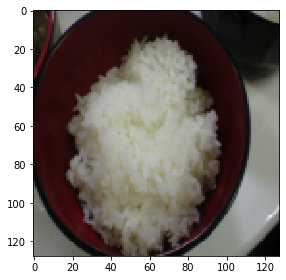

In [23]:
Test = io.imread("food-11\\food-11\\testing\\0620.jpg")
gray_test = transform.resize(Test,(128,128))
io.imshow(gray_test)
predict = model.predict(gray_test.reshape(1,128,128,3))
print(predict)
loc = np.where(predict==np.max(predict))[1][0]
print("This is "+food_dict[loc])

# 生成测试文件

In [11]:
#创建CSV文件，名为Result.csv,并构建csv写入对象
f = open('result_2.csv','w',encoding='utf-8')
csv_writer = csv.writer(f)
csv_writer.writerow(["id","category"])
food_dict={0:"饼",1:"奶酪",2:"冰淇淋",3:"蛋",4:"煎炸食品",5:"肉食",6:"面条",7:"米饭",8:"海鲜",9:"汤",10:"水果"}

#读取测试图片
test_path = "food-11\\food-11\\testing\\*.jpg"
Test = io.ImageCollection(test_path)
warnings.filterwarnings('ignore')
test_num = len(Test)
print("共有"+str(test_num)+"张图片")

Result = []
for i in range(test_num):
    gray_test = transform.resize(Test[i],(128,128))
    predict = model.predict(gray_test.reshape(1,128,128,3))
    loc = np.where(predict==np.max(predict))[1][0]
    #Result.append(loc)
    csv_writer.writerow([i,loc])
    if i%100 == 0 :
        #io.imshow(gray_test)
        print("This is "+food_dict[loc])

共有3347张图片
This is 冰淇淋
This is 冰淇淋
This is 汤
This is 海鲜
This is 汤
This is 米饭
This is 肉食
This is 汤
This is 煎炸食品
This is 面条
This is 汤
This is 饼
This is 冰淇淋
This is 汤
This is 冰淇淋
This is 水果
This is 汤
This is 煎炸食品
This is 奶酪
This is 冰淇淋
This is 冰淇淋
This is 冰淇淋
This is 煎炸食品
This is 煎炸食品
This is 肉食
This is 煎炸食品
This is 水果
This is 面条
This is 饼
This is 汤
This is 冰淇淋
This is 汤
This is 水果
This is 肉食


In [15]:
#print(len(Train_x))
#Train_x = np.array(Train_x)
#for i in range(len(Train_x)):
#    Train_x[i] = transform.resize(Train_x[i],(224,224))
#Train_x = np.array(Train_x)
print(Train_x.shape)
print(Train_y.shape)
print(Valid_x.shape)
print(Valid_y[10])

(9866, 224, 224, 3)
(9866, 11)
(3430, 224, 224, 3)
[1 0 0 0 0 0 0 0 0 0 0]


In [4]:
food_dict={0:"饼",1:"奶酪",2:"冰淇淋",3:"蛋",4:"煎炸食品",5:"肉食",6:"面条",7:"米饭",8:"海鲜",9:"汤",10:"水果"}

In [24]:
model.save('cnn_model_sgd_6.h5')

In [18]:
plot_model(model,show_shapes=True,to_file='model.png')

"C:\Program Files\Graphviz 2.44.1\bin\dot.exe" with args ['-Tps', 'C:\\Users\\TYLERL~1\\AppData\\Local\\Temp\\tmpf94pazf4'] returned code: 1

stdout, stderr:
 b''
b'Format: "ps" not recognized. Use one of:\r\n'



AssertionError: 1

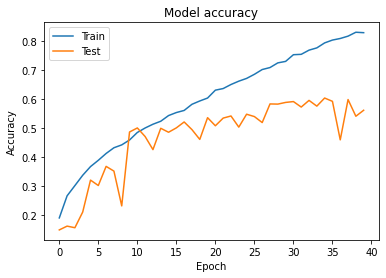

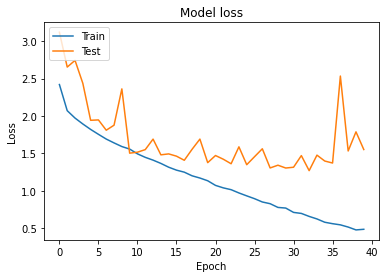

In [9]:
# 绘制训练 & 验证的准确率值
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 绘制训练 & 验证的损失值
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 64)        18496     
__________

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 64)        36928     
__________

In [19]:
K.clear_session()

In [26]:
print(Train_x.shape)

(9866, 128, 128, 3)
